In [14]:
# from transformers import AutoTokenizer, BertModel

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("ml6team/mt5-small-german-finetune-mlsum")

model = AutoModelForSeq2SeqLM.from_pretrained("ml6team/mt5-small-german-finetune-mlsum")

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

In [15]:
sentence = tokenizer.encode('Der Mann gibt dem Hund den Knochen.')
print(sentence)

In [16]:
tokenizer.decode(sentence)

'Der Mann gibt dem Hund den Knochen.</s>'

In [12]:
import sys
!{sys.executable} -m pip install protobuf

In [11]:
from deep_translator import GoogleTranslator
trans = GoogleTranslator('de','en')

In [6]:
def embedding_for_word(word):
  id = tokenizer.encode(word)[1]
  return model.embeddings.word_embeddings.weight[id].detach().numpy()

In [1]:
from weatTest import run_weat

In [ ]:
run_weat(['bert-base-german-cased', i])

In [13]:
def cosine_similarity(vec1, len1, vec2, len2):
    """calculates the cosine similarity between two vectors"""
    if type(len1) == list or type(len2) == list:
        return 0
    dot_product = np.dot(vec1, vec2)
    return dot_product / (len1 * len2)

In [67]:
sys.stdout = orig_stdout

In [40]:
!mkdir GermanGPT2_WEAT_results/

In [1]:
print('hi')

hi


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make s

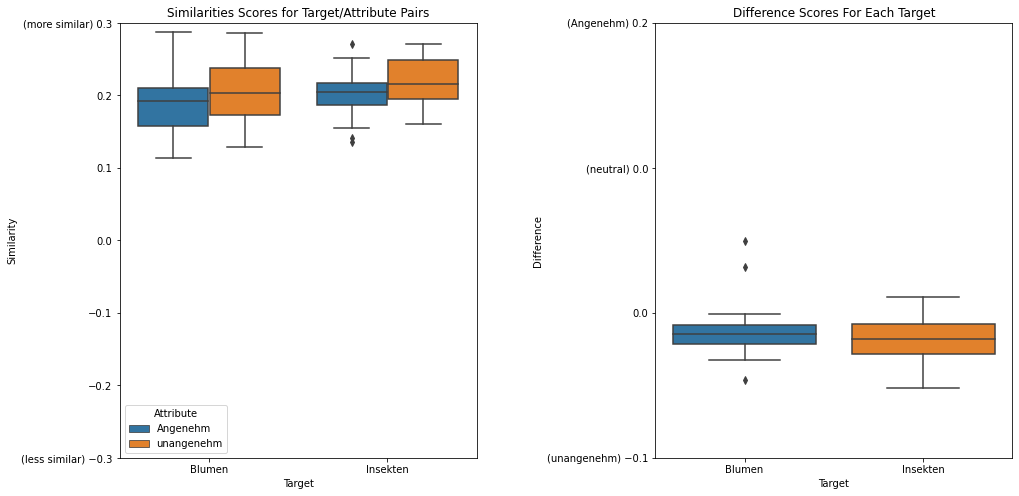

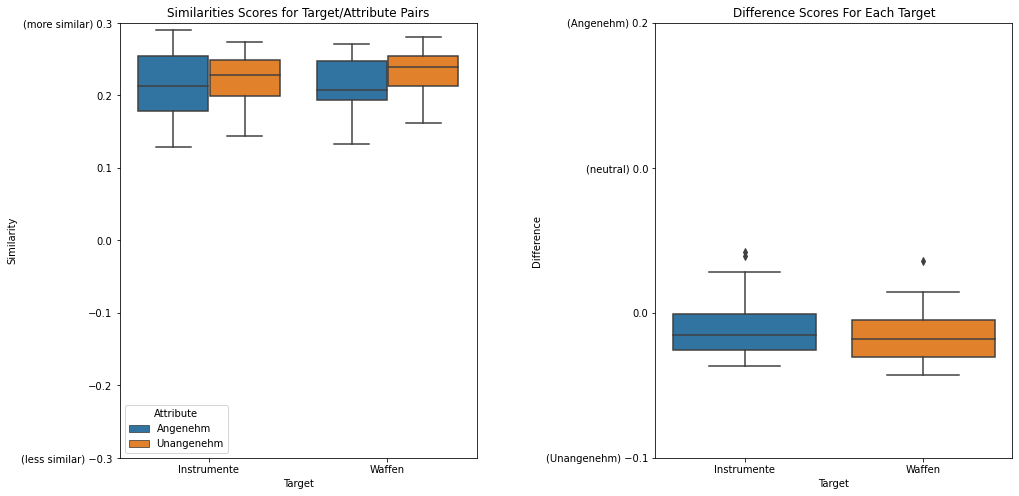

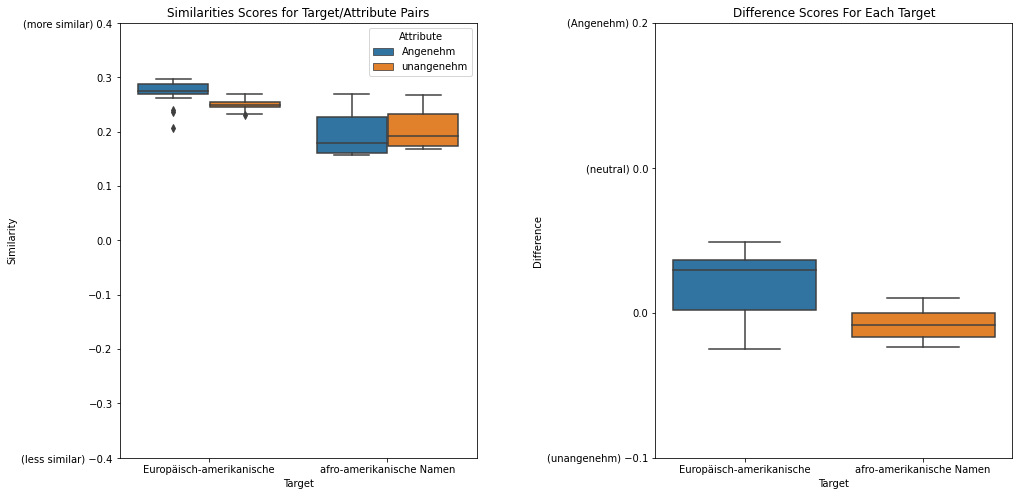

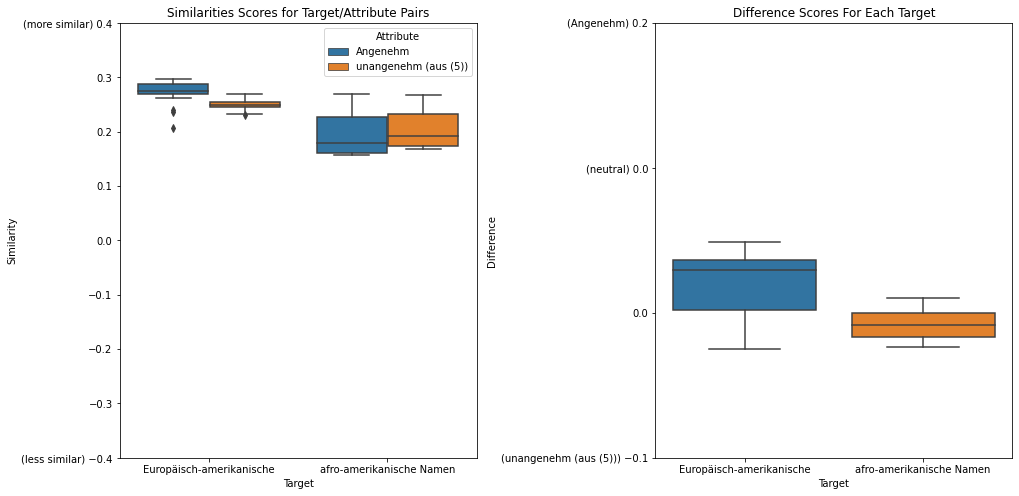

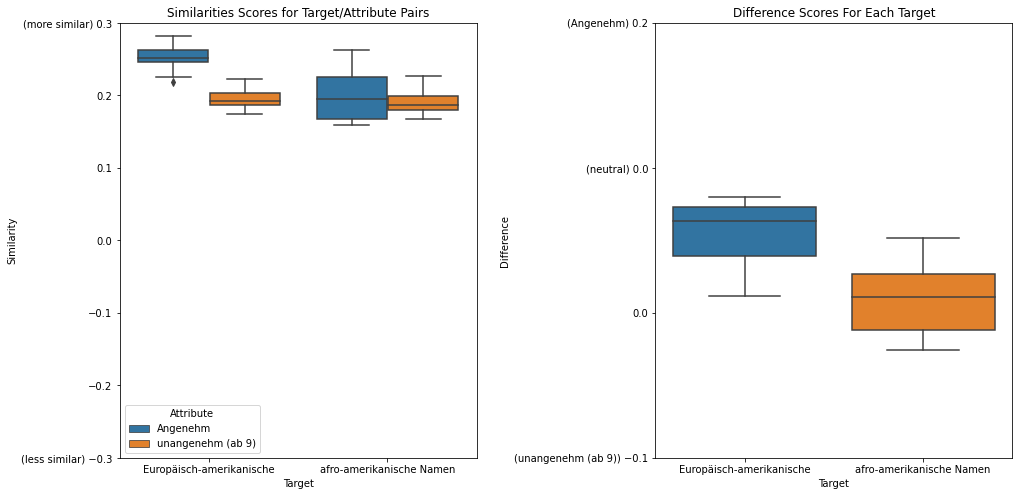

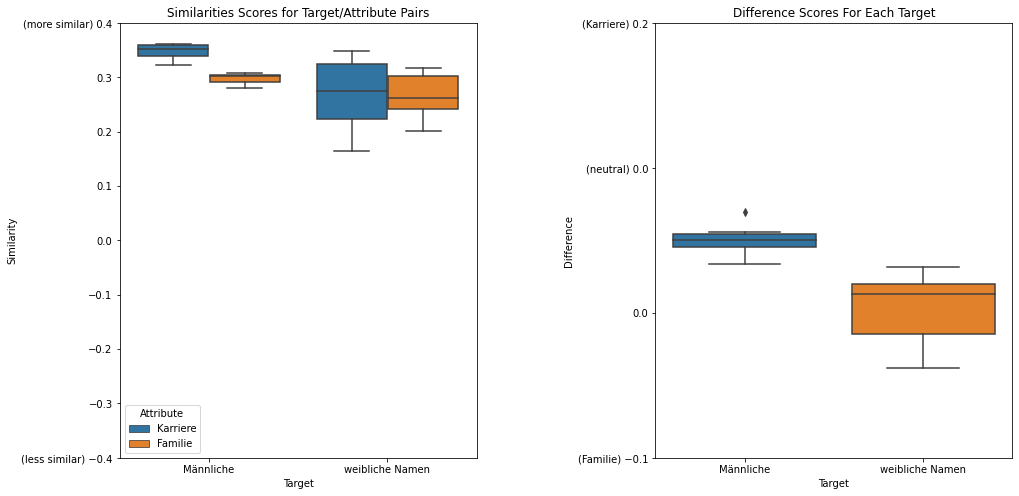

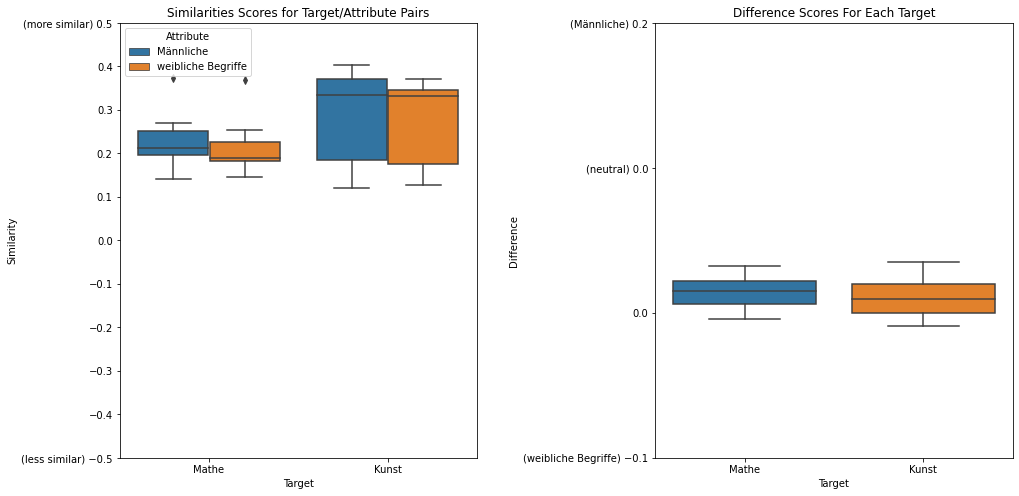

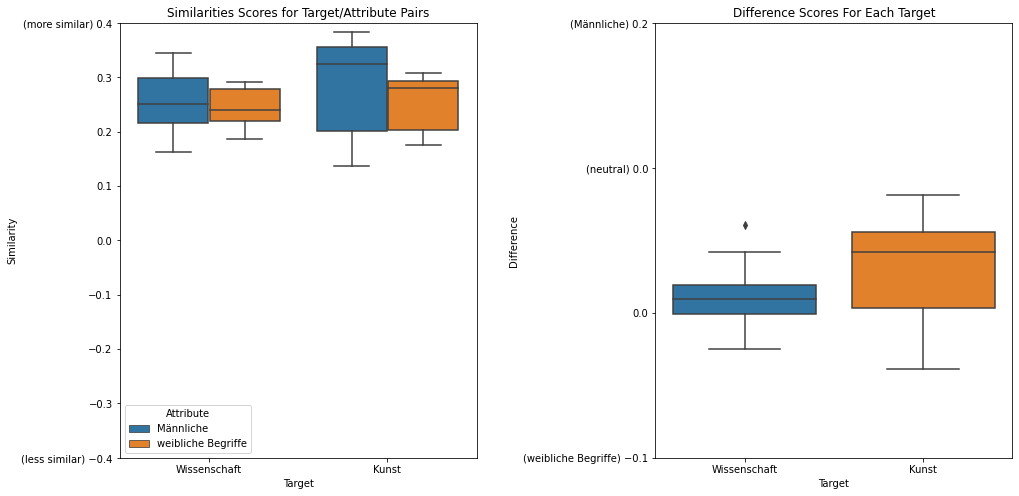

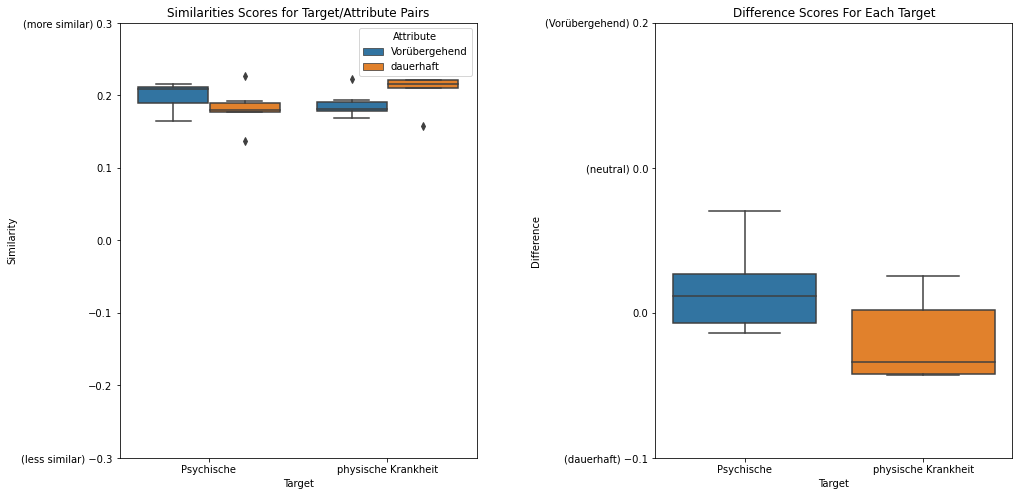

In [17]:
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM

for i in range(1,10):
    rundirect = ['gpt2', i]
    test_name = 'GermanGPT2_WEAT_results/gpt2_WEAT_test_'+str(rundirect[1])

    orig_stdout = sys.stdout
    f = open(test_name +'.txt', 'w')
    sys.stdout = f
    
    model_name = rundirect[0]
    if 'bert' in model_name:
        tokenizer = AutoTokenizer.from_pretrained('bert-base-german-cased')
        model = BertModel.from_pretrained('bert-base-german-cased')
    if 't5' in model_name:
        tokenizer = AutoTokenizer.from_pretrained("ml6team/mt5-small-german-finetune-mlsum")
        model = AutoModelForSeq2SeqLM.from_pretrained("ml6team/mt5-small-german-finetune-mlsum")
    if 'gpt2' in model_name:
        tokenizer = AutoTokenizer.from_pretrained("dbmdz/german-gpt2")
        model = AutoModelForCausalLM.from_pretrained("dbmdz/german-gpt2")

    test_num = rundirect[1]

    target1,target2,attribute1,attribute2 = loadwordlist(test_num)
    target1Name,target2Name,attribute1Name,attribute2Name = loadwordnames(test_num)

    print('WEAT Test: ', test_num)
    print('targets: ', target1Name, target2Name)
    print('attributes: ', attribute1Name, attribute2Name)

    target1Vecs, target1Lengths = getListData(target1, tokenizer, model)
    target2Vecs, target2Lengths = getListData(target2, tokenizer, model)
    attr1Data, attr1Lengths = getListData(attribute1, tokenizer, model)
    attr2Data, attr2Lengths = getListData(attribute2, tokenizer, model)
    
    print([target1Vecs.shape, target2Vecs.shape, attr1Data.shape, attr2Data.shape])

    if 't5' or 'gpt2' in model_name:
        max_shape = np.maximum.reduce([target1Vecs.shape, target2Vecs.shape, attr1Data.shape, attr2Data.shape])
        
        zero_attr = np.zeros(max_shape)
        zero_attr[:target1Vecs.shape[0],:target1Vecs.shape[1]] = target1Vecs
        target1Vecs = zero_attr

        zero_attr = np.zeros(max_shape)
        zero_attr[:target2Vecs.shape[0],:target2Vecs.shape[1]] = target2Vecs
        target2Vecs = zero_attr

        zero_attr = np.zeros(max_shape)
        zero_attr[:attr2Data.shape[0], :attr2Data.shape[1]] = attr2Data
        attr2Data = zero_attr

        zero_attr = np.zeros(max_shape)
        zero_attr[:attr1Data.shape[0], :attr1Data.shape[1]] = attr1Data
        attr1Data = zero_attr

#     Find more similar attribute words for each target list
    print("Top 5 most similar attribute words to %s:" % target1Name+ ", " + trans.translate(target1Name))

    topWordsT1 = rankAttributes(target1Vecs, target1Lengths, np.concatenate([attr1Data, attr2Data]),
            np.concatenate([attr1Lengths, attr2Lengths]), np.concatenate([attribute1, attribute2]))
    for word in topWordsT1[::-1]:
        print("\t"+word + ", " + trans.translate(word))

    print()
    print("Top 5 most similar attribute words to %s:" % target2Name + ", " + trans.translate(target2Name))

    topWordsT2 = rankAttributes(target2Vecs, target2Lengths, np.concatenate([attr1Data, attr2Data]),
            np.concatenate([attr1Lengths, attr2Lengths]), np.concatenate([attribute1, attribute2]))
    for word in topWordsT2[::-1]:
        print("\t"+word + ", " + trans.translate(word))

    print()
    #calculate similarities between target 1 and both attributes
    targ1attr1Sims = [getAverageSimilarity( target1Vecs[i], target1Lengths[i], attr1Data, attr1Lengths)
        for i in range( target1Lengths.shape[0])]
    targ1attr2Sims = [getAverageSimilarity( target1Vecs[i], target1Lengths[i], attr2Data, attr2Lengths)
        for i in range( target1Lengths.shape[0])]
    targ1SimDiff = np.subtract(targ1attr1Sims, targ1attr2Sims)

    #calculate similarities between target 2 and both attributes
    targ2attr1Sims = [getAverageSimilarity( target2Vecs[i], target2Lengths[i], attr1Data, attr1Lengths)
        for i in range( target2Lengths.shape[0])]
    targ2attr2Sims = [getAverageSimilarity( target2Vecs[i], target2Lengths[i], attr2Data, attr2Lengths)
        for i in range( target2Lengths.shape[0])]
    targ2SimDiff = np.subtract(targ2attr1Sims, targ2attr2Sims)

    #effect size is avg difference in similarities divided by standard dev
    d = (np.average(targ1SimDiff) - np.average(targ2SimDiff))/np.std(np.concatenate((targ1SimDiff,targ2SimDiff)))


    print()
    print("Calculating effect size.  The score is between +2.0 and -2.0.  ")
    print("Positive scores indicate that %s is more associated with %s than %s." % (target1Name, attribute1Name, target2Name))
    print("Or, equivalently, %s is more associated with %s than %s." % (target2Name, attribute2Name, target1Name))
    print("Negative scores have the opposite relationship.")
    print("Scores close to 0 indicate little to no effect.")
    print()
    print("Effect size: %.2f" % d)

    print()
    print("Plotting similarity scores...")

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_title("Similarities Scores for Target/Attribute Pairs")
    ax2.set_title("Difference Scores For Each Target")

    # Box plot of pairwise similarity scores
    df = pd.DataFrame()
    df["Similarity"] = np.concatenate([targ1attr1Sims,targ1attr2Sims,targ2attr1Sims,targ2attr2Sims])
    df["Pairs"] = [target1Name+"-"+attribute1Name]*len(targ1attr1Sims)+[target1Name+"-"+attribute2Name]*len(targ1attr2Sims)+[target2Name+"-"+attribute1Name]*len(targ2attr1Sims) \
      +[target2Name+"-"+attribute2Name]*len(targ2attr2Sims)
    df["Target"] = [target1Name]*len(targ1attr1Sims+targ1attr2Sims)+[target2Name]*len(targ2attr1Sims+targ2attr2Sims)
    df["Attribute"] = [attribute1Name]*len(targ1attr1Sims)+[attribute2Name]*len(targ1attr2Sims)+[attribute1Name]*len(targ2attr1Sims) +[attribute2Name]*len(targ2attr2Sims)
    sns.boxplot(x="Target", y="Similarity", hue="Attribute",data=df, ax=ax1)
    #Box plot of target bias in similarities
    df = pd.DataFrame()
    df["Difference"] = np.concatenate([targ1SimDiff, targ2SimDiff])
    df["Target"] = [target1Name]*len(targ1SimDiff) + [target2Name]*len(targ2SimDiff)
    ax = sns.boxplot(x="Target", y="Difference", data=df, ax=ax2)


    ticks = ax1.get_yticks()
    mx = max(abs(ticks[0]),ticks[-1])
    mx = int(mx*10+.99)/10.0
    ax1.yaxis.set_ticks(np.arange(-mx,mx+.1,.1))
    ticks = ax2.get_yticks()
    mx = max(abs(ticks[0]),ticks[-1])
    mx = int(mx*10+.99)/10.0
    ax2.yaxis.set_ticks(np.arange(-mx,mx+.1,.1))

    fig.subplots_adjust(wspace=0.5)
    fig.canvas.draw()

    labels = [item.get_text() for item in ax1.get_yticklabels()]
    labels[0] = "(less similar) " + labels[0]
    labels[-1] = "(more similar) " + labels[-1]
    ax1.set_yticklabels(labels)
    labels = [item.get_text() for item in ax2.get_yticklabels()]
    labels[0] = "(%s) " % attribute2Name + labels[0]
    labels[len(labels)//2] = "(neutral) 0.0"
    labels[-1] = "(%s) " % attribute1Name + labels[-1]
    ax2.set_yticklabels(labels)

    fig.savefig(test_name+'.png')

    sys.stdout = orig_stdout
    f.close()


In [16]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, BertModel
import json
datadir = "wordlists/"

def loadwordlist(test_num):
    """loads and returns all words in the given file.  Omits words not in the
    word embedding matrix"""
    if test_num > 9:
        print('Invalid WEAT Test.')
        return
    with open(datadir+"weat_tests_german.json") as f:
        weat_german = json.load(f)
        test_string = "test" + str(test_num)
        weat_test = weat_german[test_string]
    return weat_test['X'], weat_test['Y'], weat_test['A'], weat_test['B']

def loadwordnames(test_num):
    if test_num > 9:
        print('Invalid WEAT Test.')
        return
    with open(datadir+"weat_tests_german.json") as f:
        weat_german = json.load(f)
        test_string = "test" + str(test_num)
        weat_test = weat_german[test_string]
        attribute_names = weat_test['attribute_words'].split(' vs. ')
        word_names = weat_test['target_words'].split(' vs. ')
    return word_names[0], word_names[1], attribute_names[0], attribute_names[1]

def getAverageSimilarity(targetVec, targetLength, attrVectors, attrLengths):
    """Calculates average similarity between words in the target list and attribute
    list"""
    return np.average([cosine_similarity(targetVec, targetLength, attrVectors[i], attrLengths[i]) for i in range(attrLengths.shape[0])])

def getListData(conceptWords, tokenizer, transformer):
    vectors = []
    lengths = []
    biggest_shape = []
    for target_idx in range(len(conceptWords)):
        if len(conceptWords[target_idx]) > 0:
            if 'bert' in model_name:
                word_id = tokenizer.encode(conceptWords[target_idx])[1]
                v = transformer.embeddings.word_embeddings.weight[word_id].detach().numpy()
            if 't5' in model_name:
                word_id = tokenizer(conceptWords[target_idx], return_tensors="pt")

                # forward pass through encoder only
                output = transformer.encoder(
                    input_ids=word_id["input_ids"], 
                    attention_mask=word_id["attention_mask"], 
                    return_dict=True
                )
                # get the final hidden states
                v = output.last_hidden_state.detach().numpy()
                biggest_shape.append(v.shape)
            if 'gpt2' in model_name:
                word_id = tokenizer.encode(conceptWords[target_idx])
                v = model.transformer.wte.weight[word_id,:].detach().numpy()
                biggest_shape.append(v.shape)
            vectors.append(v)
            lengths.append(np.linalg.norm(v))
    if 't5' in model_name:
        biggest_shape = np.maximum.reduce([np.array(b) for b in biggest_shape])
        padded_vectors = []
        for v in vectors:
            vec_zeros = np.zeros(biggest_shape)
            vec_zeros[:v.shape[0],:v.shape[1],:v.shape[2]] = v
            padded_vectors.append(vec_zeros.reshape(-1))
        vectors = padded_vectors
    if 'gpt2' in model_name:
        biggest_shape = np.maximum.reduce([np.array(b) for b in biggest_shape])
        padded_vectors = []
        for v in vectors:
            vec_zeros = np.zeros(biggest_shape)
            vec_zeros[:v.shape[0],:v.shape[1]] = v
            padded_vectors.append(vec_zeros.reshape(-1))
        vectors = padded_vectors
    vectors = np.array(vectors)
    lengths = np.array(lengths)
    return (vectors, lengths)

def rankAttributes(targetData, targetLengths, attrData, attrLengths, attrWords, n= 5):
    """Return the n highest similarity scores between the target and all attr"""
    attrSims = [getAverageSimilarity(attrData[i], attrLengths[i], targetData, targetLengths) for i in range(attrLengths.shape[0])]
    return attrWords[np.argsort(attrSims)[-n:]]

def run_weat(rundirect, male_word_lists=False):
    #parse inputs, load in glove vectors and wordlists
    tokenizer = AutoTokenizer.from_pretrained(rundirect[0])
    model = BertModel.from_pretrained(rundirect[0])

    test_num = rundirect[1]

    target1,target2,attribute1,attribute2 = loadwordlist(test_num)
    target1Name,target2Name,attribute1Name,attribute2Name = loadwordnames(test_num)

    print('WEAT Test: ', test_num)
    print('targets: ', target1Name, target2Name)
    print('attributes: ', attribute1Name, attribute2Name)

    target1Vecs, target1Lengths = getListData(target1, tokenizer, model)
    target2Vecs, target2Lengths = getListData(target2, tokenizer, model)
    attr1Data, attr1Lengths = getListData(attribute1, tokenizer, model)
    attr2Data, attr2Lengths = getListData(attribute2, tokenizer, model)
    
    print(len(target1Vecs), len(target1Lengths))
    
    #Find more similar attribute words for each target list
    print()
    print("Top 5 most similar attribute words to %s:" % target1Name)

    topWordsT1 = rankAttributes(target1Vecs, target1Lengths, np.concatenate([attr1Data, attr2Data]),
            np.concatenate([attr1Lengths, attr2Lengths]), np.array([attribute1[0], attribute2[0]]))
    for word in topWordsT1[::-1]:
        print("\t"+word)

    print()
    print("Top 5 most similar attribute words to %s:" % target2Name)

    topWordsT2 = rankAttributes(target1Vecs, target1Lengths, np.concatenate([attr1Data, attr2Data]),
            np.concatenate([attr1Lengths, attr2Lengths]), np.array([attribute1[1], attribute2[1]]))
    for word in topWordsT2[::-1]:
        print("\t"+word)

    print()
    #calculate similarities between target 1 and both attributes
    targ1attr1Sims = [getAverageSimilarity( target1Vecs[i], target1Lengths[i], attr1Data, attr1Lengths)
        for i in range( target1Vecs.shape[0])]
    targ1attr2Sims = [getAverageSimilarity( target1Vecs[i], target1Lengths[i], attr2Data, attr2Lengths)
        for i in range( target1Vecs.shape[0])]
    targ1SimDiff = np.subtract(targ1attr1Sims, targ1attr2Sims)

    #calculate similarities between target 2 and both attributes
    targ2attr1Sims = [getAverageSimilarity( target2Vecs[i], target2Lengths[i], attr1Data, attr1Lengths)
        for i in range( target2Vecs.shape[0])]
    targ2attr2Sims = [getAverageSimilarity( target2Vecs[i], target2Lengths[i], attr2Data, attr2Lengths)
        for i in range( target2Vecs.shape[0])]
    targ2SimDiff = np.subtract(targ2attr1Sims, targ2attr2Sims)

    #effect size is avg difference in similarities divided by standard dev
    d = (np.average(targ1SimDiff) - np.average(targ2SimDiff))/np.std(np.concatenate((targ1SimDiff,targ2SimDiff)))


    print()
    print("Calculating effect size.  The score is between +2.0 and -2.0.  ")
    print("Positive scores indicate that %s is more associated with %s than %s." % (target1Name, attribute1Name, target2Name))
    print("Or, equivalently, %s is more associated with %s than %s." % (target2Name, attribute2Name, target1Name))
    print("Negative scores have the opposite relationship.")
    print("Scores close to 0 indicate little to no effect.")
    print()
    print("Effect size: %.2f" % d)

    print()
    print("Plotting similarity scores...")

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_title("Similarities Scores for Target/Attribute Pairs")
    ax2.set_title("Difference Scores For Each Target")

    # Box plot of pairwise similarity scores
    df = pd.DataFrame()
    df["Similarity"] = np.concatenate([targ1attr1Sims,targ1attr2Sims,targ2attr1Sims,targ2attr2Sims])
    df["Pairs"] = [target1Name+"-"+attribute1Name]*len(targ1attr1Sims)+[target1Name+"-"+attribute2Name]*len(targ1attr2Sims)+[target2Name+"-"+attribute1Name]*len(targ2attr1Sims) \
      +[target2Name+"-"+attribute2Name]*len(targ2attr2Sims)
    df["Target"] = [target1Name]*len(targ1attr1Sims+targ1attr2Sims)+[target2Name]*len(targ2attr1Sims+targ2attr2Sims)
    df["Attribute"] = [attribute1Name]*len(targ1attr1Sims)+[attribute2Name]*len(targ1attr2Sims)+[attribute1Name]*len(targ2attr1Sims) +[attribute2Name]*len(targ2attr2Sims)
    sns.boxplot(x="Target", y="Similarity", hue="Attribute",data=df, ax=ax1)
    #Box plot of target bias in similarities
    df = pd.DataFrame()
    df["Difference"] = np.concatenate([targ1SimDiff, targ2SimDiff])
    df["Target"] = [target1Name]*len(targ1SimDiff) + [target2Name]*len(targ2SimDiff)
    ax = sns.boxplot(x="Target", y="Difference", data=df, ax=ax2)


    ticks = ax1.get_yticks()
    mx = max(abs(ticks[0]),ticks[-1])
    mx = int(mx*10+.99)/10.0
    ax1.yaxis.set_ticks(np.arange(-mx,mx+.1,.1))
    ticks = ax2.get_yticks()
    mx = max(abs(ticks[0]),ticks[-1])
    mx = int(mx*10+.99)/10.0
    ax2.yaxis.set_ticks(np.arange(-mx,mx+.1,.1))

    fig.subplots_adjust(wspace=0.5)
    fig.canvas.draw()

    labels = [item.get_text() for item in ax1.get_yticklabels()]
    labels[0] = "(less similar) " + labels[0]
    labels[-1] = "(more similar) " + labels[-1]
    ax1.set_yticklabels(labels)
    labels = [item.get_text() for item in ax2.get_yticklabels()]
    labels[0] = "(%s) " % attribute2Name + labels[0]
    labels[len(labels)//2] = "(neutral) 0.0"
    labels[-1] = "(%s) " % attribute1Name + labels[-1]
    ax2.set_yticklabels(labels)

    return plt